In [2]:
# env: sex_diff
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import permutation_test

import os

## Draw site prediction plots
### Data: HCPA, HCPD; YA from 3 disease cohort (same acquisition as original A, D)
#### (1) load single flavor results (logistic regression)
#### (2) get ensemble results of original connectomes
#### (3) load ensemble covbat, Krakencoder results
#### (4) draw sex prediction accuracy across models

In [ ]:
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101] 
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']

flavor = 'SCifod2act_fs86_volnormicv'
data = scipy.io.loadmat(f'/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/{flavor}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]stratifiedCV_split0328_test30newYA_train_downsampledtrain30site.mat')
n_connectivity = data['8-11'][0][0][0].shape[1]

In [ ]:
def load_data(flavor, outer_folds=100, bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101], mul_etiv=False):
    data = scipy.io.loadmat(f'/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/{flavor}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]stratifiedCV_split0328_test30newYA_train_downsampledtrain30site.mat')
    return data

sc_shen268_ifod2act = load_data('SCifod2act_shen268_volnormicv')
sc_fs86_ifod2act = load_data('SCifod2act_fs86_volnormicv')
sc_cocommpsuit439_ifod2act = load_data('SCifod2act_coco439_volnormicv')

sc_shen268_sdstream = load_data('SCsdstream_shen268_volnormicv')
sc_fs86_sdstream = load_data('SCsdstream_fs86_volnormicv')
sc_cocommpsuit439_sdstream = load_data('SCsdstream_coco439_volnormicv')

fc_shen268_FCcov_hpfgsr = load_data('FCcorr_shen268_hpfgsr')
fc_fs86_FCcov_hpfgsr = load_data('FCcorr_fs86_hpfgsr')
fc_cocommpsuit439_FCcov_hpfgsr = load_data('FCcorr_coco439_hpfgsr')

fc_shen268_FCcov_hpf = load_data('FCcorr_shen268_hpf')
fc_fs86_FCcov_hpf = load_data('FCcorr_fs86_hpf')
fc_cocommpsuit439_FCcov_hpf = load_data('FCcorr_coco439_hpf')

fc_shen268_FCpcorr_hpf = load_data('FCpcorr_shen268_hpf')
fc_fs86_FCpcorr_hpf = load_data('FCpcorr_fs86_hpf')
fc_cocommpsuit439_FCpcorr_hpf = load_data('FCpcorr_coco439_hpf')

In [5]:
# all flavors
flavors = [fc_fs86_FCcov_hpf, fc_fs86_FCcov_hpfgsr, fc_fs86_FCpcorr_hpf, sc_fs86_ifod2act, sc_fs86_sdstream, 
           fc_shen268_FCcov_hpf, fc_shen268_FCcov_hpfgsr, fc_shen268_FCpcorr_hpf, sc_shen268_ifod2act, sc_shen268_sdstream,
           fc_cocommpsuit439_FCcov_hpf, fc_cocommpsuit439_FCcov_hpfgsr, fc_cocommpsuit439_FCpcorr_hpf, sc_cocommpsuit439_ifod2act, sc_cocommpsuit439_sdstream]
flavorsFC = [fc_fs86_FCcov_hpf, fc_fs86_FCcov_hpfgsr, fc_fs86_FCpcorr_hpf, 
           fc_shen268_FCcov_hpf, fc_shen268_FCcov_hpfgsr, fc_shen268_FCpcorr_hpf,
           fc_cocommpsuit439_FCcov_hpf, fc_cocommpsuit439_FCcov_hpfgsr, fc_cocommpsuit439_FCpcorr_hpf]
flavorsSC = [sc_fs86_ifod2act, sc_fs86_sdstream, sc_shen268_ifod2act, sc_shen268_sdstream, sc_cocommpsuit439_ifod2act, sc_cocommpsuit439_sdstream]

flavors_name = ['fc_fs86_FCcov_hpf', 'fc_fs86_FCcov_hpfgsr', 'fc_fs86_FCpcorr_hpf', 'sc_fs86_ifod2act', 'sc_fs86_sdstream', 
           'fc_shen268_FCcov_hpf', 'fc_shen268_FCcov_hpfgsr', 'fc_shen268_FCpcorr_hpf', 'sc_shen268_ifod2act', 'sc_shen268_sdstream',
           'fc_cocommpsuit439_FCcov_hpf', 'fc_cocommpsuit439_FCcov_hpfgsr', 'fc_cocommpsuit439_FCpcorr_hpf', 'sc_cocommpsuit439_ifod2act', 'sc_cocommpsuit439_sdstream']

In [6]:
from scipy.stats import mode
from sklearn.metrics import recall_score

ensemble_reps = []
ensembleFC_reps = []
ensembleSC_reps = []

ensemble_mean = []
ensembleSC_mean = []
ensembleFC_mean = []
for age in group_labels1:
    sc_shen268_test = sc_shen268_sdstream[age][0][0][4]
    true = sc_shen268_test[:,0,:]
    # fusion results
    test_results = []
    for i in range(len(flavors)):
        arr = flavors[i][age][0][0][4]   # (100, 30)
        pred = arr[:,1,:]
        test_results.append(pred)
    preds = np.stack(test_results, axis=0)
    ensemble_pred = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5).argmax(), axis=0, arr=preds
    ) 
    baccs = [recall_score(true[r], ensemble_pred[r], labels=[0,1,2,3,4], average="macro", zero_division=0) for r in range(true.shape[0])]   # 100 accuracies
    ensemble_reps.append(baccs)    
    ensemble_mean.append(np.mean(baccs))

    # FC only
    test_results = []
    for i in range(len(flavorsFC)):
        arr = flavorsFC[i][age][0][0][4]
        pred = arr[:, 1, :]
        test_results.append(pred)
    preds = np.stack(test_results, axis=0)
    ensemble_pred = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5).argmax(), axis=0, arr=preds
    )
    baccs_FC = [recall_score(true[r], ensemble_pred[r], labels=[0,1,2,3,4], average="macro", zero_division=0) for r in range(true.shape[0])]   # 100 accuracies
    ensembleFC_reps.append(baccs_FC)    
    ensembleFC_mean.append(np.mean(baccs_FC))

    # SC only
    test_results = []
    for i in range(len(flavorsSC)):
        arr = flavorsSC[i][age][0][0][4]
        pred = arr[:, 1, :]
        test_results.append(pred)
    preds = np.stack(test_results, axis=0)
    ensemble_pred = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=5).argmax(), axis=0, arr=preds
    )
    baccs_SC = [recall_score(true[r], ensemble_pred[r], labels=[0,1,2,3,4], average="macro", zero_division=0) for r in range(true.shape[0])]   # 100 accuracies
    ensembleSC_reps.append(baccs_SC)
    ensembleSC_mean.append(np.mean(baccs_SC))

In [ ]:
def kraken_compare_site(data_use, bins, group_labels, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fig_size):
    outer_folds = 100
    n_bins      = len(bins) - 1
    fusion_types = [
        ('FCs Only (Fusion FC)',  'fusionFC'),
        ('SCs (Fusion SC)', 'fusionSC'),
        ('FCs + SCs (Fusion)', 'fusion')
    ]

    base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95'
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.flatten()

    palette={'random chance': 'red',
              'Sex - Site Fine-tuned Krakencoder': 'pink', 
             'Sex Fine-tuned Krakencoder': '#C875C4',
            #'Fine-tuned Krakencoder': '#70B38E',
            'Krakencoder': 'coral',
            'Ensemble': 'steelblue',
            'Ensemble Covbat': 'lightblue'} 

    handles = []
    labels = []

    with open('/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/covbat/covbat_ensemble_reps0912_site.pkl', 'rb') as f:
        ensemblecb_data = pickle.load(f)
        ensemblecb_reps = ensemblecb_data['ensemble_reps']
        ensemblecbFC_reps = ensemblecb_data['ensembleFC_reps']
        ensemblecbSC_reps = ensemblecb_data['ensembleSC_reps']

    for ax, (title, fusion_key) in zip(axes[:3], fusion_types):
        dfs = []

        # build the ensemble_covbat DataFrame…

        if fusion_key == 'fusion':
            repcb_list = ensemblecb_reps; enscb_label = 'Ensemble Covbat'
        elif fusion_key == 'fusionFC':
            repcb_list = ensemblecbFC_reps; enscb_label = 'Ensemble Covbat'
        else:
            repcb_list = ensemblecbSC_reps; enscb_label = 'Ensemble Covbat'

        repcb_list = [np.asarray(r) for r in repcb_list]
        enscb_arr  = np.array(repcb_list).T   # shape = (100, n_bins)
        enscb_df   = pd.DataFrame(enscb_arr, columns=group_labels)
        enscb_df['model'] = enscb_label
        dfs.append(enscb_df)

        # build the ensemble DataFrame…
        if fusion_key == 'fusion':
            rep_list = ensemble_reps; ens_label = 'Ensemble'
        elif fusion_key == 'fusionFC':
            rep_list = ensembleFC_reps; ens_label = 'Ensemble'
        else:
            rep_list = ensembleSC_reps; ens_label = 'Ensemble'

        rep_list = [np.asarray(r) for r in rep_list]
        ens_arr  = np.array(rep_list).T   # shape = (100, n_bins)
        ens_df   = pd.DataFrame(ens_arr, columns=group_labels)
        ens_df['model'] = ens_label
        dfs.append(ens_df)

        # load Krakencoder variants…
        for label, subdir in [
            ('Krakencoder',            'krakencoder_original'),
            ('Sex Fine-tuned Krakencoder','krakencoder500_sex0508'),
            ('Sex - Site Fine-tuned Krakencoder', 'krakencoder500_sex0508_site_rm'),
            ('random chance', 'krakencoder500_sex0508_permute')
        ]:
            path = os.path.join(
                base_dir,
                subdir,
                f'results1110/encoded_pred{fusion_key}{bins}{data_use}_logistic_site.mat'
            )
            mat = scipy.io.loadmat(path, simplify_cells=True)
            arr = np.zeros((outer_folds, n_bins))
            for i in range(n_bins):
                key = f"{bins[i]}-{bins[i+1]}"
                arr[:, i] = mat[key]['test_accuracy'].ravel()
            df = pd.DataFrame(arr, columns=group_labels)
            df['model'] = label
            dfs.append(df)


        df_long = pd.concat(dfs, ignore_index=True).melt(
            id_vars='model', var_name='age_group', value_name='accuracy'
        )
        df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=group_labels, ordered=True)
        sns.boxplot(
            x='age_group', y='accuracy',
            hue='model', data=df_long,
            dodge=True, ax=ax, palette = palette
        )

        x = np.arange(0, len(group_labels))
        med_df = (df_long.groupby(['model','age_group'], observed=False)['accuracy'].median().reset_index())
        x_smooth = np.linspace(0, len(group_labels)-1, 500)
        offset_map = {
            'Ensemble Covbat': -0.5,
            'Ensemble': -0.25,
            'Krakencoder': -0.1,
            'Sex Fine-tuned Krakencoder': +0.1,
            'Sex - Site Fine-tuned Krakencoder': +0.3,
            'random chance': +0.5
        }
        for model_label, color in palette.items():
            dx = offset_map[model_label]
            m = med_df[med_df['model']==model_label]
            medians = m.set_index('age_group').reindex(group_labels)['accuracy'].values
            spl = make_interp_spline(x, medians, k=3)

        ax.set_title(title)
        ax.set_xlabel("Age Range")
        ax.set_ylabel("Balanced Accuracy")
        ax.set_ylim(-0.03, 0.7)
        ax.tick_params(axis='x', rotation=45)
        if not handles:
            handles, labels = ax.get_legend_handles_labels()

        ax.get_legend().remove()
        axes[3].axis('off')

    fig.legend(handles, labels, title="Model", loc='center right', bbox_to_anchor=(0.78, 0.3))
    fig.text(0.02, 0.97, "b)", fontsize=17, ha='right')   
    plt.tight_layout()
    #plt.savefig("/home/keh4016/ke_storage/sex_age_diff/HCP/out_log/figures/site_acc.png", dpi=500)
    plt.show()

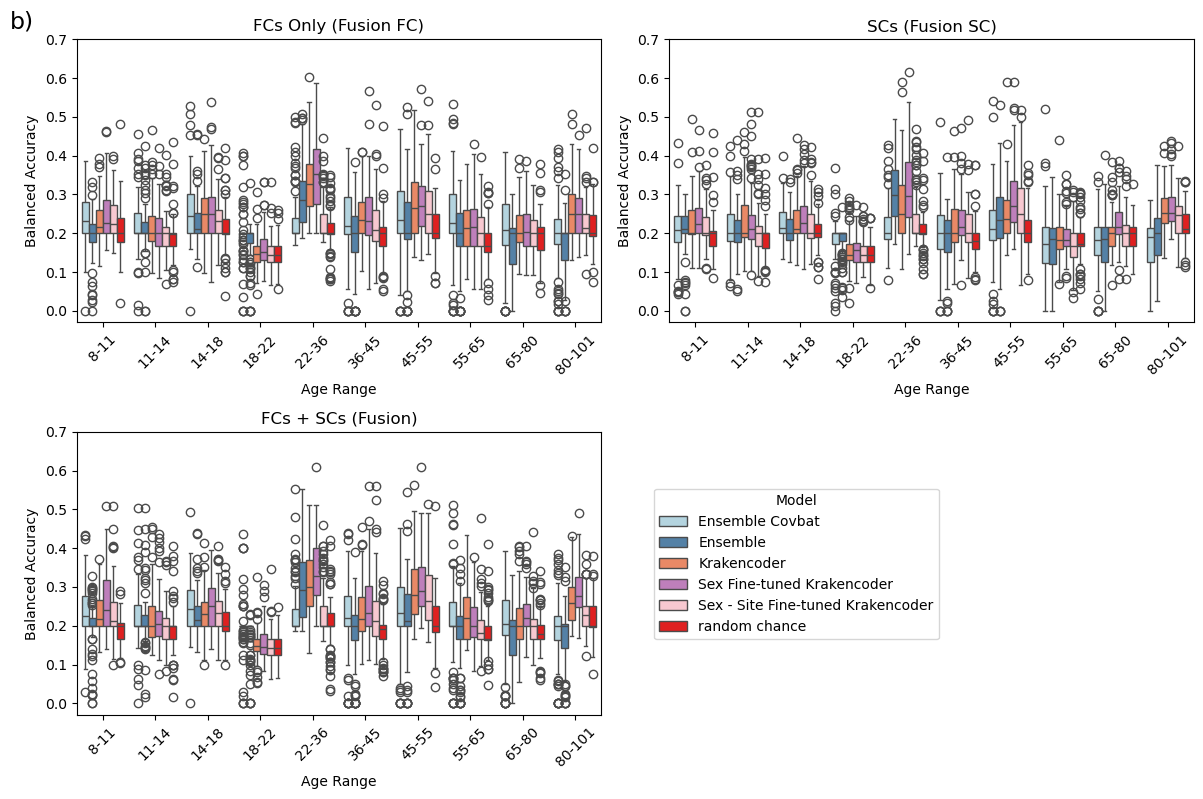

In [8]:
# seed 42
bin = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
kraken_compare_site('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, (12, 8))

### Permutation test on site acc across models

In [ ]:
from scipy.stats import permutation_test
from statsmodels.stats.multitest import multipletests


def kraken_site_sig(data_use, bins, group_labels, ensemble_reps, ensembleFC_reps, ensembleSC_reps,
                    fusiontype_index, compare_to="Sex Fine-tuned Krakencoder", base_model = 'Ensemble Covbat'):

    # ==== ensure full printing ====
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    outer_folds = 100
    n_bins = len(bins) - 1

    fusion_types = [
        ('FCs Only (Fusion FC)',  'fusionFC'),
        ('SCs (Fusion SC)',       'fusionSC'),
        ('FCs + SCs (Fusion)',    'fusion')
    ]

    # ----- select fusion type -----
    title, fusion_key = fusion_types[fusiontype_index]

    base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95'

    # Load ensemble covbat reps
    with open('/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/covbat/covbat_ensemble_reps0912_site.pkl', 'rb') as f:
        ensemblecb_data = pickle.load(f)
        ensemblecb_reps   = ensemblecb_data['ensemble_reps']
        ensemblecbFC_reps = ensemblecb_data['ensembleFC_reps']
        ensemblecbSC_reps = ensemblecb_data['ensembleSC_reps']

    # =============== build dfs (same as before) ===============
    dfs = []

    # Ensemble Covbat
    if fusion_key == 'fusion':
        repcb_list = ensemblecb_reps
    elif fusion_key == 'fusionFC':
        repcb_list = ensemblecbFC_reps
    else:
        repcb_list = ensemblecbSC_reps

    repcb_arr = np.array([np.asarray(r) for r in repcb_list]).T
    enscb_df = pd.DataFrame(repcb_arr, columns=group_labels)
    enscb_df['model'] = 'Ensemble Covbat'
    dfs.append(enscb_df)

    # Ensemble
    if fusion_key == 'fusion':
        rep_list = ensemble_reps
    elif fusion_key == 'fusionFC':
        rep_list = ensembleFC_reps
    else:
        rep_list = ensembleSC_reps

    rep_arr = np.array([np.asarray(r) for r in rep_list]).T
    ens_df = pd.DataFrame(rep_arr, columns=group_labels)
    ens_df['model'] = 'Ensemble'
    dfs.append(ens_df)

    # Krakencoder variants
    model_variants = [
        ('Krakencoder',                      'krakencoder_original'),
        ('Sex Fine-tuned Krakencoder',       'krakencoder500_sex0508'),
        ('Sex - Site Fine-tuned Krakencoder','krakencoder500_sex0508_site_rm'),
        ('random chance',                    'krakencoder500_sex0508_permute')
    ]

    for label, subdir in model_variants:
        path = os.path.join(
            base_dir, subdir,
            f'results1110/encoded_pred{fusion_key}{bins}{data_use}_logistic_site.mat'
        )
        mat = scipy.io.loadmat(path, simplify_cells=True)
        arr = np.zeros((outer_folds, n_bins))

        for i in range(n_bins):
            key = f"{bins[i]}-{bins[i+1]}"
            arr[:, i] = mat[key]['test_accuracy'].ravel()

        df_model = pd.DataFrame(arr, columns=group_labels)
        df_model['model'] = label
        dfs.append(df_model)

    # ================= merge long DF ==================
    df_long = pd.concat(dfs, ignore_index=True).melt(
        id_vars='model', var_name='age_group', value_name='accuracy'
    )
    df_long['age_group'] = pd.Categorical(df_long['age_group'],
                                          categories=group_labels,
                                          ordered=True)

    # =====================================================
    # PERMUTATION TEST: compare base_model vs ANY MODEL
    # =====================================================

    model_site = base_model #"Sex - Site Fine-tuned Krakencoder" / 'Ensemble Covbat'
    model_other = compare_to  # passed by user

    print(f"\nComparing: **{model_site} vs {model_other}** on fusion {title}")

    df_comp = df_long[df_long['model'].isin([model_site, model_other])]

    stats_list = []
    pvals = []

    for age in group_labels:
        acc_site = df_comp[(df_comp['age_group']==age) &
                           (df_comp['model']==model_site)]['accuracy'].to_numpy()

        acc_other = df_comp[(df_comp['age_group']==age) &
                            (df_comp['model']==model_other)]['accuracy'].to_numpy()

        if len(acc_site)==0 or len(acc_other)==0:
            pvals.append(np.nan)
            stats_list.append(np.nan)
            continue

        stat_func = lambda a, b: np.mean(a) - np.mean(b)  # site - other

        res = permutation_test(
            (acc_site, acc_other),
            statistic=stat_func,
            n_resamples=10000,
            alternative='two-sided'
        )

        stats_list.append(res.statistic)
        pvals.append(res.pvalue)

    # results table
    perm_df = pd.DataFrame({
        "age_bin": group_labels,
        "perm_stat (site - other)": stats_list,
        "p_raw": pvals
    })

    perm_df["p_fwer"] = multipletests(perm_df["p_raw"], method="fdr_bh")[1]
    perm_df["reject_fwer"] = perm_df["p_fwer"] < 0.05
    print(perm_df)

    return 

#### Compare sex-site Krakencoder with other site predictions

In [66]:
# seed 42
bin = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, 
                compare_to='Sex Fine-tuned Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Sex Fine-tuned Krakencoder** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.010999  0.211179  0.263974        False
1   11-14                 -0.007941  0.320568  0.356187        False
2   14-18                 -0.026807  0.005399  0.017998         True
3   18-22                 -0.011618  0.068193  0.113655        False
4   22-36                 -0.112794  0.000200  0.002000         True
5   36-45                 -0.020290  0.050795  0.101590        False
6   45-55                 -0.009790  0.363564  0.363564        False
7   55-65                 -0.021426  0.015598  0.038996         True
8   65-80                 -0.010241  0.172983  0.247118        False
9  80-101                 -0.025306  0.001000  0.005000         True


In [68]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Sex Fine-tuned Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Sex Fine-tuned Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Sex Fine-tuned Krakencoder** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.019590  0.008999  0.017998         True
1   11-14                 -0.025375  0.010999  0.018332         True
2   14-18                 -0.022115  0.013399  0.019141         True
3   18-22                 -0.003332  0.543146  0.543146        False
4   22-36                 -0.075612  0.000200  0.001000         True
5   36-45                 -0.013679  0.114789  0.127543        False
6   45-55                 -0.027009  0.030197  0.037746         True
7   55-65                 -0.026245  0.000200  0.001000         True
8   65-80                 -0.021987  0.004400  0.010999         True
9  80-101                 -0.024510  0.001400  0.004666         True

Comparing: **Sex - Site Fine-tuned Krakencoder vs Sex Fine-tuned Krakencoder** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site

In [69]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, compare_to='Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Krakencoder** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.008990  0.250775  0.313469        False
1   11-14                 -0.020058  0.013999  0.046662         True
2   14-18                 -0.018551  0.027397  0.068493        False
3   18-22                 -0.002797  0.626137  0.626137        False
4   22-36                 -0.093418  0.000200  0.002000         True
5   36-45                 -0.017336  0.063394  0.105656        False
6   45-55                 -0.010646  0.324168  0.360186        False
7   55-65                 -0.015818  0.059794  0.105656        False
8   65-80                 -0.010163  0.179582  0.256546        False
9  80-101                 -0.035757  0.000400  0.002000         True


In [70]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Krakencoder', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Krakencoder** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.011948  0.122988  0.204980        False
1   11-14                 -0.028630  0.003000  0.027331         True
2   14-18                 -0.009397  0.262974  0.375677        False
3   18-22                 -0.003923  0.507949  0.634937        False
4   22-36                 -0.030674  0.008199  0.027331         True
5   36-45                 -0.004596  0.591941  0.657712        False
6   45-55                  0.018747  0.090391  0.180782        False
7   55-65                 -0.021587  0.005799  0.027331         True
8   65-80                  0.002301  0.752725  0.752725        False
9  80-101                 -0.014160  0.051195  0.127987        False

Comparing: **Sex - Site Fine-tuned Krakencoder vs Krakencoder** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site - other)     p_raw    p_fwer 

In [71]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, compare_to='Ensemble', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Ensemble** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.042550  0.000200  0.000333         True
1   11-14                 -0.013241  0.092591  0.115738        False
2   14-18                  0.009446  0.213979  0.237754        False
3   18-22                 -0.026615  0.000200  0.000333         True
4   22-36                 -0.054945  0.000200  0.000333         True
5   36-45                  0.036901  0.001000  0.001428         True
6   45-55                  0.055685  0.000200  0.000333         True
7   55-65                  0.005651  0.573943  0.573943        False
8   65-80                  0.035144  0.000200  0.000333         True
9  80-101                  0.056708  0.000200  0.000333         True


In [72]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Ensemble', base_model = 'Sex - Site Fine-tuned Krakencoder')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Ensemble', base_model = 'Sex - Site Fine-tuned Krakencoder')


Comparing: **Sex - Site Fine-tuned Krakencoder vs Ensemble** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.007483  0.304770  0.380962        False
1   11-14                 -0.006040  0.471553  0.523948        False
2   14-18                  0.009808  0.179582  0.256546        False
3   18-22                 -0.028584  0.000200  0.000667         True
4   22-36                 -0.063661  0.000200  0.000667         True
5   36-45                  0.031991  0.000600  0.001500         True
6   45-55                  0.029804  0.018798  0.031330         True
7   55-65                  0.001164  0.894711  0.894711        False
8   65-80                  0.026209  0.003600  0.007199         True
9  80-101                  0.050461  0.000200  0.000667         True

Comparing: **Sex - Site Fine-tuned Krakencoder vs Ensemble** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  rejec

#### Compare ensmeble covbat with other site predictions

In [73]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, 
                compare_to='Sex Fine-tuned Krakencoder')


Comparing: **Ensemble Covbat vs Sex Fine-tuned Krakencoder** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.011970  0.207979  0.297113        False
1   11-14                  0.012403  0.165983  0.276639        False
2   14-18                 -0.002424  0.838116  0.874713        False
3   18-22                  0.035986  0.000200  0.000667         True
4   22-36                 -0.112228  0.000200  0.000667         True
5   36-45                 -0.019347  0.116188  0.232377        False
6   45-55                 -0.036469  0.004200  0.010499         True
7   55-65                  0.004580  0.726727  0.874713        False
8   65-80                 -0.001669  0.874713  0.874713        False
9  80-101                 -0.059343  0.000200  0.000667         True


In [74]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Sex Fine-tuned Krakencoder')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Sex Fine-tuned Krakencoder')


Comparing: **Ensemble Covbat vs Sex Fine-tuned Krakencoder** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.024020  0.007399  0.010570         True
1   11-14                 -0.011103  0.270373  0.270373        False
2   14-18                 -0.014212  0.073993  0.082214        False
3   18-22                  0.023040  0.000800  0.001600         True
4   22-36                 -0.099336  0.000200  0.000500         True
5   36-45                 -0.029827  0.005799  0.009666         True
6   45-55                 -0.075849  0.000200  0.000500         True
7   55-65                 -0.026499  0.009799  0.012249         True
8   65-80                 -0.048274  0.000200  0.000500         True
9  80-101                 -0.094764  0.000200  0.000500         True

Comparing: **Ensemble Covbat vs Sex Fine-tuned Krakencoder** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  rejec

In [75]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, compare_to='Krakencoder')


Comparing: **Ensemble Covbat vs Krakencoder** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.008019  0.356364  0.593941        False
1   11-14                  0.000287  0.988701  0.988701        False
2   14-18                  0.005832  0.554345  0.692931        False
3   18-22                  0.044806  0.000200  0.000667         True
4   22-36                 -0.092851  0.000200  0.000667         True
5   36-45                 -0.016393  0.141786  0.283572        False
6   45-55                 -0.037325  0.007199  0.017998         True
7   55-65                  0.010188  0.419758  0.599654        False
8   65-80                 -0.001591  0.891711  0.988701        False
9  80-101                 -0.069794  0.000200  0.000667         True


In [76]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Krakencoder')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Krakencoder')


Comparing: **Ensemble Covbat vs Krakencoder** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                 -0.016378  0.071393  0.089241        False
1   11-14                 -0.014359  0.131187  0.145763        False
2   14-18                 -0.001494  0.855714  0.855714        False
3   18-22                  0.022449  0.000800  0.002666         True
4   22-36                 -0.054399  0.000200  0.001000         True
5   36-45                 -0.020745  0.052995  0.075707        False
6   45-55                 -0.030094  0.010999  0.021998         True
7   55-65                 -0.021841  0.035196  0.058661        False
8   65-80                 -0.023986  0.009599  0.021998         True
9  80-101                 -0.084415  0.000200  0.001000         True

Comparing: **Ensemble Covbat vs Krakencoder** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11              

In [77]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=0, compare_to='Ensemble')


Comparing: **Ensemble Covbat vs Ensemble** on fusion FCs Only (Fusion FC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.041578  0.000200  0.001000         True
1   11-14                  0.007103  0.439156  0.439156        False
2   14-18                  0.033829  0.000400  0.001333         True
3   18-22                  0.020989  0.011999  0.019998         True
4   22-36                 -0.054378  0.000200  0.001000         True
5   36-45                  0.037844  0.001800  0.003600         True
6   45-55                  0.029006  0.039996  0.049995         True
7   55-65                  0.031657  0.016398  0.023426         True
8   65-80                  0.043716  0.000800  0.002000         True
9  80-101                  0.022670  0.046995  0.052217        False


In [78]:
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=1, compare_to='Ensemble')
kraken_site_sig('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fusiontype_index=2, compare_to='Ensemble')


Comparing: **Ensemble Covbat vs Ensemble** on fusion SCs (Fusion SC)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.003053  0.712129  0.904660        False
1   11-14                  0.008231  0.331167  0.551945        False
2   14-18                  0.017711  0.006199  0.030997         True
3   18-22                 -0.002212  0.723728  0.904660        False
4   22-36                 -0.087385  0.000200  0.002000         True
5   36-45                  0.015842  0.145585  0.299170        False
6   45-55                 -0.019036  0.149585  0.299170        False
7   55-65                  0.000909  0.933907  0.982902        False
8   65-80                 -0.000078  0.982902  0.982902        False
9  80-101                 -0.019793  0.027597  0.091991        False

Comparing: **Ensemble Covbat vs Ensemble** on fusion FCs + SCs (Fusion)
  age_bin  perm_stat (site - other)     p_raw    p_fwer  reject_fwer
0    8-11                  0.